## Imports

In [42]:
import numpy as np
import pandas as pd

import gymnasium as gym

from dicl.main import dicl

import importlib
importlib.reload(dicl)

<module 'dicl.main.dicl' from '/home/abenechehab/dicl/src/dicl/main/dicl.py'>

## Load LLM model and tokenizer

In [2]:
import torch
from transformers import LlamaForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print("finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
print("finish loading model")
model.eval()

/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


finish loading tokenizer
finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

## Load data

* Problem parameters

In [7]:
env_name = "HalfCheetah"
data_label = 'expert'
data_path = f"data/D4RL_{env_name}_{data_label}.csv"
context_length = 500
rescale_factor = 7.0
up_shift = 1.5

* Sample an episode and extract in-context trajectory

In [8]:
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]

# load some data to get a sample episode
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype("float")

# find episodes beginnings
restart_index = n_observations + n_actions + 1  # restart column
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

# sample an episode and extract time series
episode = np.random.choice(episode_starts)
time_series = X[episode : episode + context_length, : n_observations + n_actions]

/home/abenechehab/miniconda3/envs/DICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:531: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


## DICL

* Instantiate DICL

In [43]:
DICL = dicl.DICL_PCA(
    n_features=n_observations + n_actions,
    n_components=5,
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)

* Fit disentangler (this can be done using a bigger dataset than the in-context time series)

In [44]:
DICL.fit_disentangler(X=time_series)

### Single-step prediction and visualization

In [45]:
mean, mode, lb, ub = DICL.predict_single_step(X=time_series)

# print metrics
burnin = 100
single_step_metrics = DICL.compute_single_step_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}\n")
print("average_agg_squared_error: "
      f"{single_step_metrics['average_agg_squared_error']:.3f}")
print(f"agg_ks: {single_step_metrics['agg_ks']}\n")

ValueError: operands could not be broadcast together with shapes (23,) (100,) 

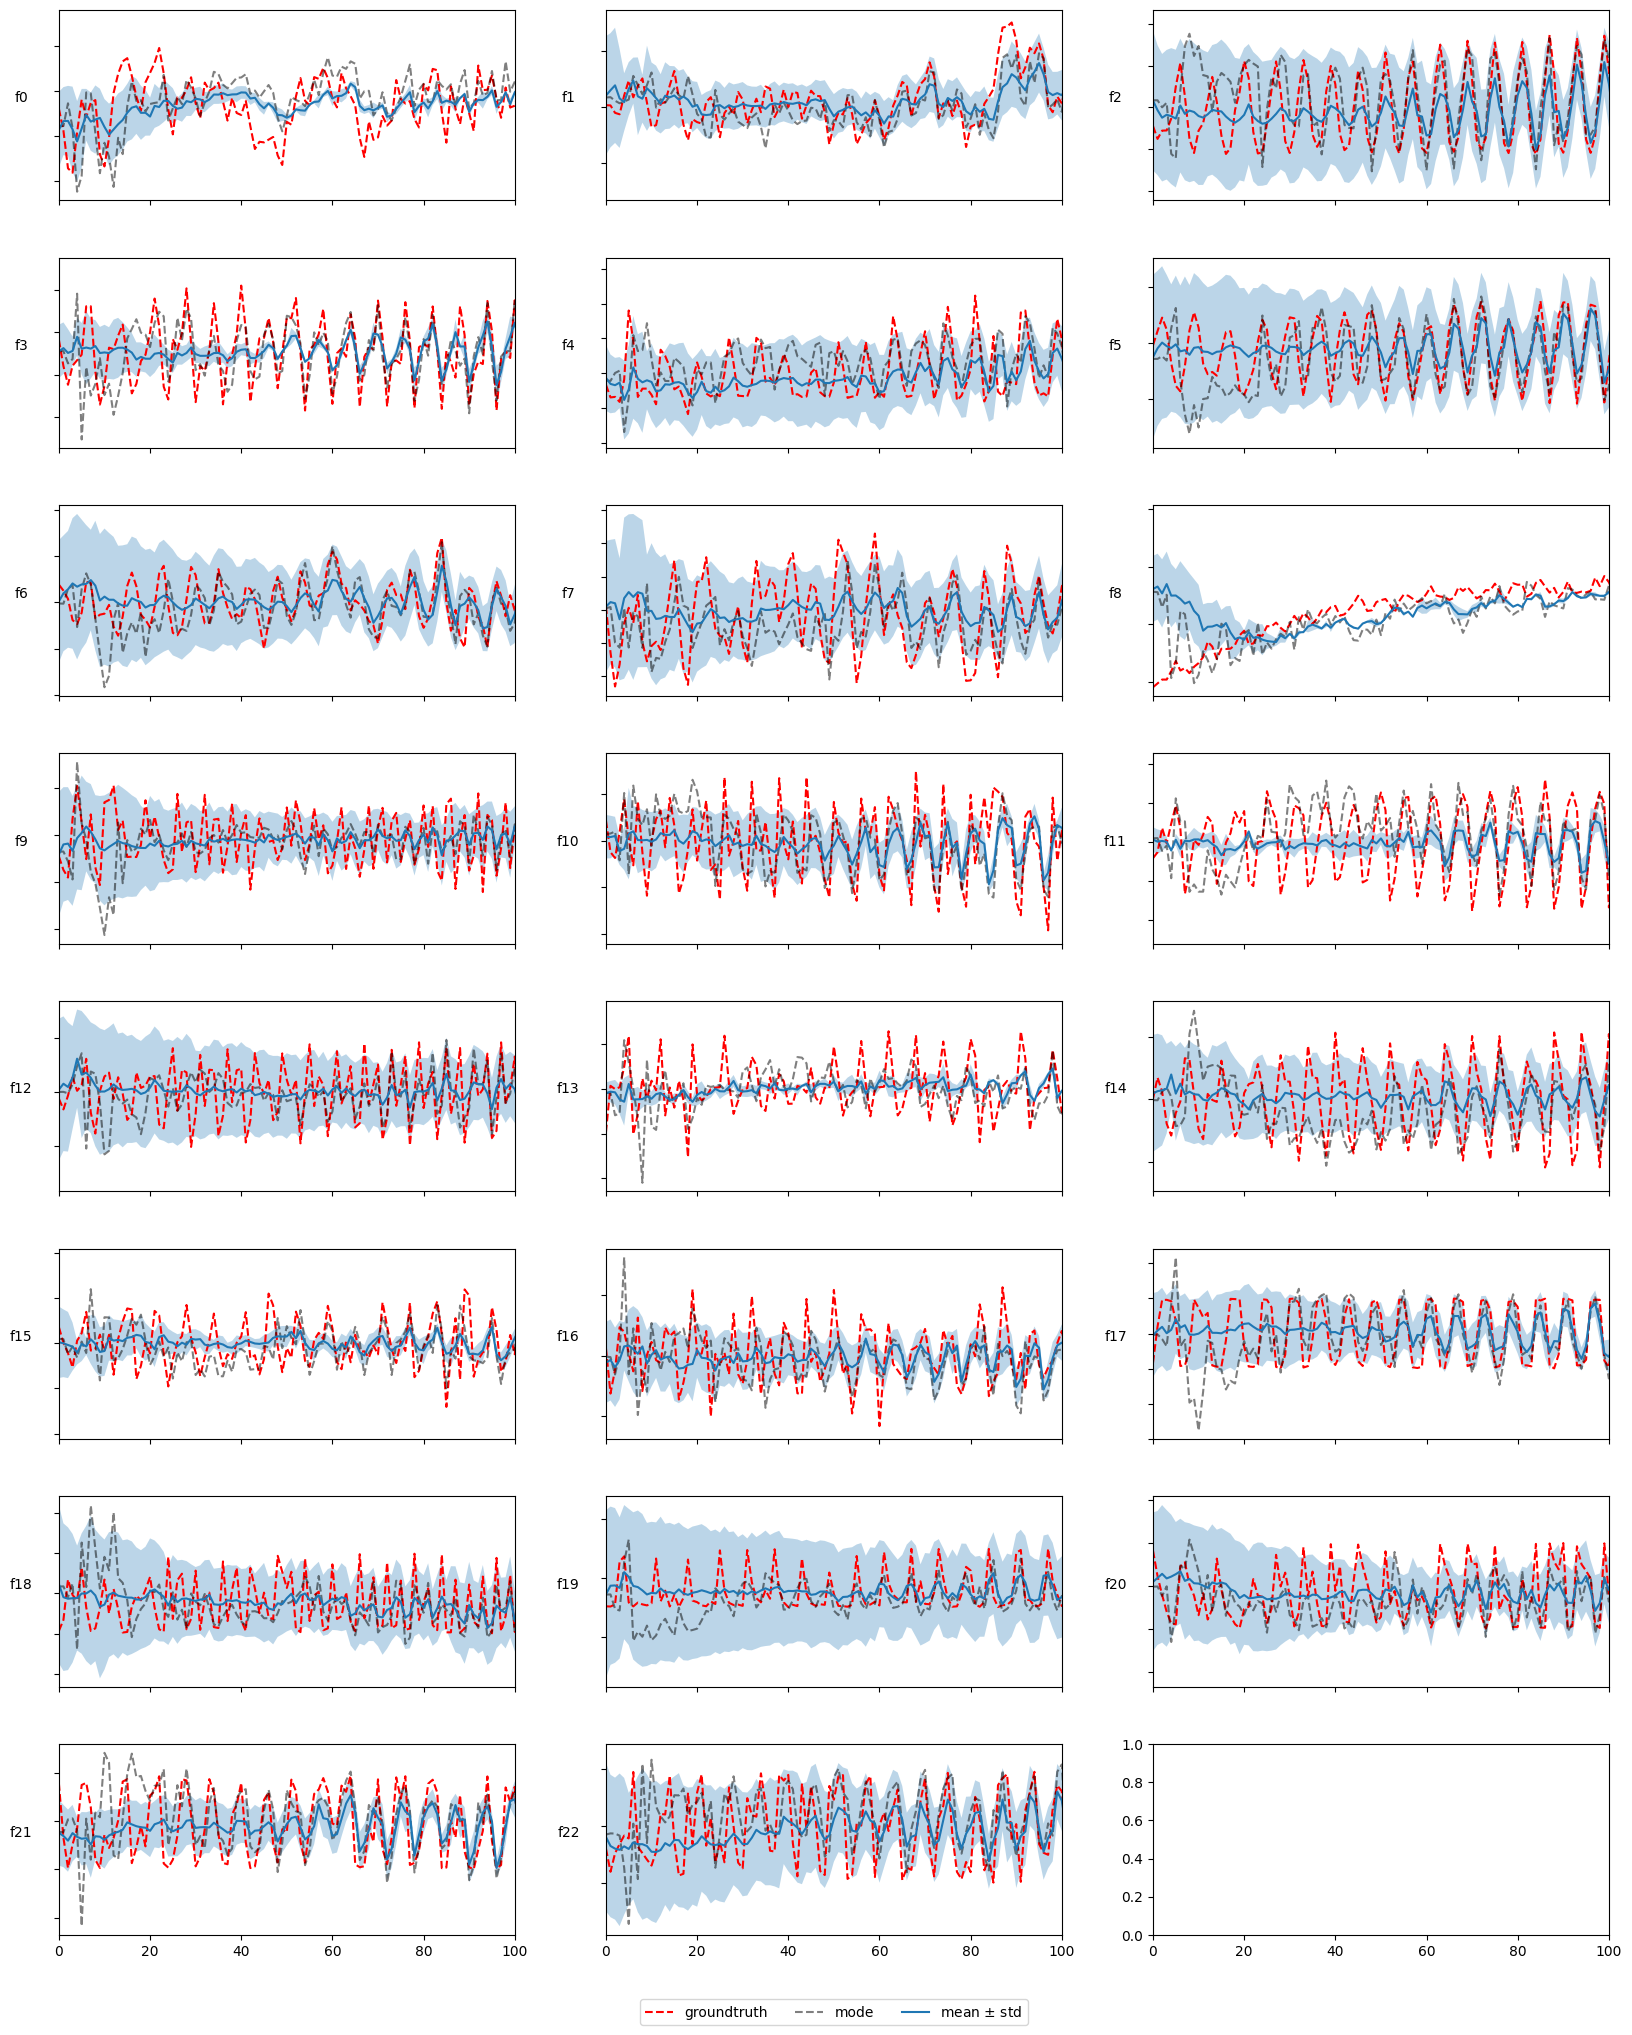

In [36]:
DICL.plot_single_step(xlim=[0, 100])

### Multi-step prediction and visualization